# Nuoseklių sakinių klasifikavimas atsitiktinių imčių medicininių tyrimų santraukose (galutinis modelis)

Dokumente "[**Neural Networks for Joint Sentence Classification in Medical Paper Abstracts**](https://arxiv.org/pdf/1612.05251)" sudarytas ANN modelis pasiekė ~90% tikslumą po mokymo su visais **PubMed 20k RCT** rinkinio pavyzdžiais. Mūsų geriausias Modelis 5, mokytas su 10% **PubMed 20k RCT** pavyzdžių, santraukų sakinių klasifikaciją atlieka ~85% tikslumu.

Šiame etape sudarysim NSK Modelį, kuris eksperimentų metu buvo sudarytas kaip Modelis 5, ir apmokysim su visais **PubMed 20k RCT** rinkinio pavyzdžiais, mokymą atliekant daugiau nei 5 epochas.

In [54]:
# bibliotekų importavimas
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import tensorflow as tf
from tensorflow.keras import layers
from keras.utils import plot_model

In [3]:
# išjungiam TensorFlow įspėjimų (warnings) vaizdavimą rezultatuose
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# glabalios TensorFlow random seed reikšmės nustatymas
tf.random.set_seed(42)

In [4]:
# pagalbinių funkcijų importavimas
from helper_functions.dataset_functions import *

In [7]:
# parametrai gauti eksperimentavimo metu

# santraukos sakinio išskirstyto žodžiais vektoriaus dydis
output_sentence_len = 55

# santraukos sakinio išskirstyto simboliais vektoriaus dydis
output_sentence_chars_len = 290

# simbolių embedding'o vetoriaus dydis
max_char_tokens = 28

# dažniausiai psikartojančių sakinių numerių dydis
line_numbers_depth = 17

# didžiausia dalį santraukų sudarančių sakinių sakičius
sentences_total_depth = 22

## Duomenų paruošimas

### Pandas DataFrame sudarymas

In [13]:
# duomenų rinkinio tekstinių failų nuskaitymas
DATASET_PATH = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

_, train_dicts = convert_file_lines_to_dic(DATASET_PATH + 'train.txt')
_, test_dicts = convert_file_lines_to_dic(DATASET_PATH + 'test.txt')
_, val_dicts = convert_file_lines_to_dic(DATASET_PATH + 'dev.txt')

In [14]:
# pandas DataFrame sudarymas
train_df = pd.DataFrame(train_dicts)
test_df = pd.DataFrame(test_dicts)
val_df = pd.DataFrame(val_dicts)

In [15]:
# sakinių sąrašų sudarymas
X_train = train_df["text"].to_list()
X_test = test_df["text"].to_list()
X_val = val_df["text"].to_list()

In [26]:
# sakinių išskaidytų simboliais sąrašas
X_train_chars = [split_sentence_chars(sentence) for sentence in X_train]
X_test_chars = [split_sentence_chars(sentence) for sentence in X_test]
X_val_chars = [split_sentence_chars(sentence) for sentence in X_val]

### Duomenų formato pakeitimas (encoding)

In [16]:
# sakinių etikėčių kodavimas su LabelEncoder
label_encoder = LabelEncoder()

y_train_label = label_encoder.fit_transform(train_df["target"])
y_test_label = label_encoder.transform(test_df["target"])   
y_val_label = label_encoder.transform(val_df["target"])

etiketes = label_encoder.classes_

In [17]:
# sakinių etikėčių kodavimas TensorFlow modeliui su OneHotEncoder
onehot_encoder = OneHotEncoder(sparse_output=False)

y_train_onehot = onehot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
y_test_onehot = onehot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))   
y_val_onehot = onehot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))

In [19]:
# sakinių numerių kodavimas su TensorFlow OneHot nurodant gylį
train_line_numbers_onehot = tf.one_hot(train_df["number"].to_numpy(), depth=line_numbers_depth)
test_line_numbers_onehot = tf.one_hot(test_df["number"].to_numpy(), depth=line_numbers_depth)
val_line_numbers_onehot = tf.one_hot(val_df["number"].to_numpy(), depth=line_numbers_depth)

In [20]:
# santraukų sakinių skaičiaus kodavimas su TensorFlow OneHot nurodant gylį
train_sentences_total_onehot = tf.one_hot(train_df["total"].to_numpy(), depth=sentences_total_depth)
test_sentences_total_onehot = tf.one_hot(test_df["total"].to_numpy(), depth=sentences_total_depth)
val_sentences_total_onehot = tf.one_hot(val_df["total"].to_numpy(), depth=sentences_total_depth)

### TensorFlow Dataset sudarymas

In [27]:
# training Dataset sudarymas
train_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_onehot,
                                                 train_sentences_total_onehot,
                                                 X_train,
                                                 X_train_chars))

train_labels = tf.data.Dataset.from_tensor_slices(y_train_onehot)

train_dataset = tf.data.Dataset.zip((train_data, train_labels)).batch(32).prefetch(tf.data.AUTOTUNE)

In [28]:
# testing Dataset sudarymas
test_data = tf.data.Dataset.from_tensor_slices((test_line_numbers_onehot,
                                                test_sentences_total_onehot,
                                                X_test,
                                                X_test_chars))

test_labels = tf.data.Dataset.from_tensor_slices(y_test_onehot)

test_dataset = tf.data.Dataset.zip((test_data, test_labels)).batch(32).prefetch(tf.data.AUTOTUNE)

In [29]:
# validation TensorFlow Dataset sudarymas
val_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_onehot,
                                               val_sentences_total_onehot,
                                               X_val,
                                               X_val_chars))

val_labels = tf.data.Dataset.from_tensor_slices(y_val_onehot)

val_dataset = tf.data.Dataset.zip((val_data, val_labels)).batch(32).prefetch(tf.data.AUTOTUNE)

## Modelio sudarymas

### Žodžių vektorizacijos sluoksnio paruošimas (Universal Sentence Encoder)

In [34]:
# importuojam TensorFlow Hub modulį
import tensorflow_hub as hub

# atsisiunčiam if TF Hub Universal Sentence Encoder
word_tokens_embedder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4", # nuoroda į iš anksto apmokyta modelį
                                            trainable=False, # nurodome nekeisti modelio išmoktų savybių
                                            name="universal_sentence_encoder")

### Simbolių vektorizacijos sluoksnio paruošimas

In [36]:
# sukuriam vektorizavimo sluoksnį
char_vectorizer = layers.TextVectorization(max_tokens=max_char_tokens,
                                           output_sequence_length=output_sentence_chars_len,
                                           name="char_vectorizer")

# sukuriam tokenizacijos žodyną naudojant į simbolius išskaidytus X_train_chars sakinius
char_vectorizer.adapt(X_train_chars)

In [37]:
# tokenizacijos metu sudaryto žodyno apžvalga
char_tokens_vocabulary = char_vectorizer.get_vocabulary()

In [38]:
#  sukuriam simbolių embedding'o sluoksnį
char_tokens_embedder_layer = layers.Embedding(input_dim=len(char_tokens_vocabulary),
                                              output_dim=24, # rezultato vektoriaus dydis
                                              mask_zero=True, # paslepiam vektorizuoto sakinio tuščias reikšmes
                                              name="char_tokens_embedding")

### Įvedimų sluoksniai

In [35]:
# žodžių vektorizacijos sluoksnio modelio su USE sudarymas
word_tokens_inputs = layers.Input(shape=[], dtype=tf.string, name="sentence_word_tokens_inputs")
word_tokens_embeddings = word_tokens_embedder_layer(word_tokens_inputs)
word_tokens_outputs = layers.Dense(128, activation="relu")(word_tokens_embeddings)

word_tokens_inputs_model = tf.keras.Model(word_tokens_inputs, word_tokens_outputs)

In [39]:
# simbolių vektorizacijos sluoksnio modelio sudarymas
char_tokens_inputs = layers.Input(shape=(1,), dtype=tf.string, name="sentence_char_tokens_inputs")
chars_vectors = char_vectorizer(char_tokens_inputs)
chars_tokens_embeddings = char_tokens_embedder_layer(chars_vectors)
char_tokens_outputs = layers.Bidirectional(layers.LSTM(32))(chars_tokens_embeddings)

char_tokens_inputs_model = tf.keras.Model(char_tokens_inputs, char_tokens_outputs)

In [40]:
# sakinio numerio įvedimo sluoksnio sudarymas
line_number_inputs = layers.Input(shape=(line_numbers_depth,), dtype=tf.float32, name="sentence_line_number_inputs")
line_number_outputs = layers.Dense(32, activation="relu")(line_number_inputs)

line_number_inputs_model = tf.keras.Model(line_number_inputs, line_number_outputs)

In [41]:
# santrauko, kurioje yra skinys eilučių skaičiaus įvedimo sluoksnio sudarymas
total_lines_inputs = layers.Input(shape=(sentences_total_depth,), dtype=tf.float32, name="sentence_total_lines_inputs")
total_lines_outputs = layers.Dense(32, activation="relu")(total_lines_inputs)

total_lines_inputs_model = tf.keras.Model(total_lines_inputs, total_lines_outputs)

### Įvedimų sluoksnių sujungimas

In [44]:
# žodžių ir simbolių vektorizacijos sluoksnių sujungimas
concat_words_chars_inputs = layers.Concatenate(name="concatenated_words_chars_inputs")([word_tokens_inputs_model.output,
                                                                                         char_tokens_inputs_model.output])
# įvedimo duomenų regulerizacija ir modelio išvedimo formavimas
concat_words_chars_dense = layers.Dense(units=256, activation="relu")(concat_words_chars_inputs)
concat_words_chars_outputs = layers.Dropout(0.5)(concat_words_chars_dense) # paminėtas dokumento 4.2 skyriuje

In [45]:
# visų įvedimų sluoksnių sujungimas
concat_inputs = layers.Concatenate(name="concatenated_words_chars_positionals_inputs")([line_number_inputs_model.output,
                                                                                        total_lines_inputs_model.output,
                                                                                        concat_words_chars_outputs])

### Išvedimo sluoksnis

In [47]:
# pridedam papildomą Dense sluoksnį, dokumente jo nera, +2%
concat_inputs_dense = layers.Dense(128, activation="relu")(concat_inputs)

# formuojam išvedimo sluoksnį
output_layer = layers.Dense(len(etiketes), activation="softmax", name="output_layer")(concat_inputs_dense)

### Modelio aprašymas ir sudarymas

In [50]:
# modelio aprašymas
model = tf.keras.Model(inputs=[line_number_inputs_model.input,
                               total_lines_inputs_model.input,
                               word_tokens_inputs_model.input,
                               char_tokens_inputs_model.input],
                       outputs=output_layer,
                       name="nsk_modelis")

In [51]:
# modelio sudarymas (kompiliavimas)
# sukūriam (kompiliuojam) aprašytą modelį
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [53]:
# išvedam sudaryto modelio struktūrą
# model.summary()

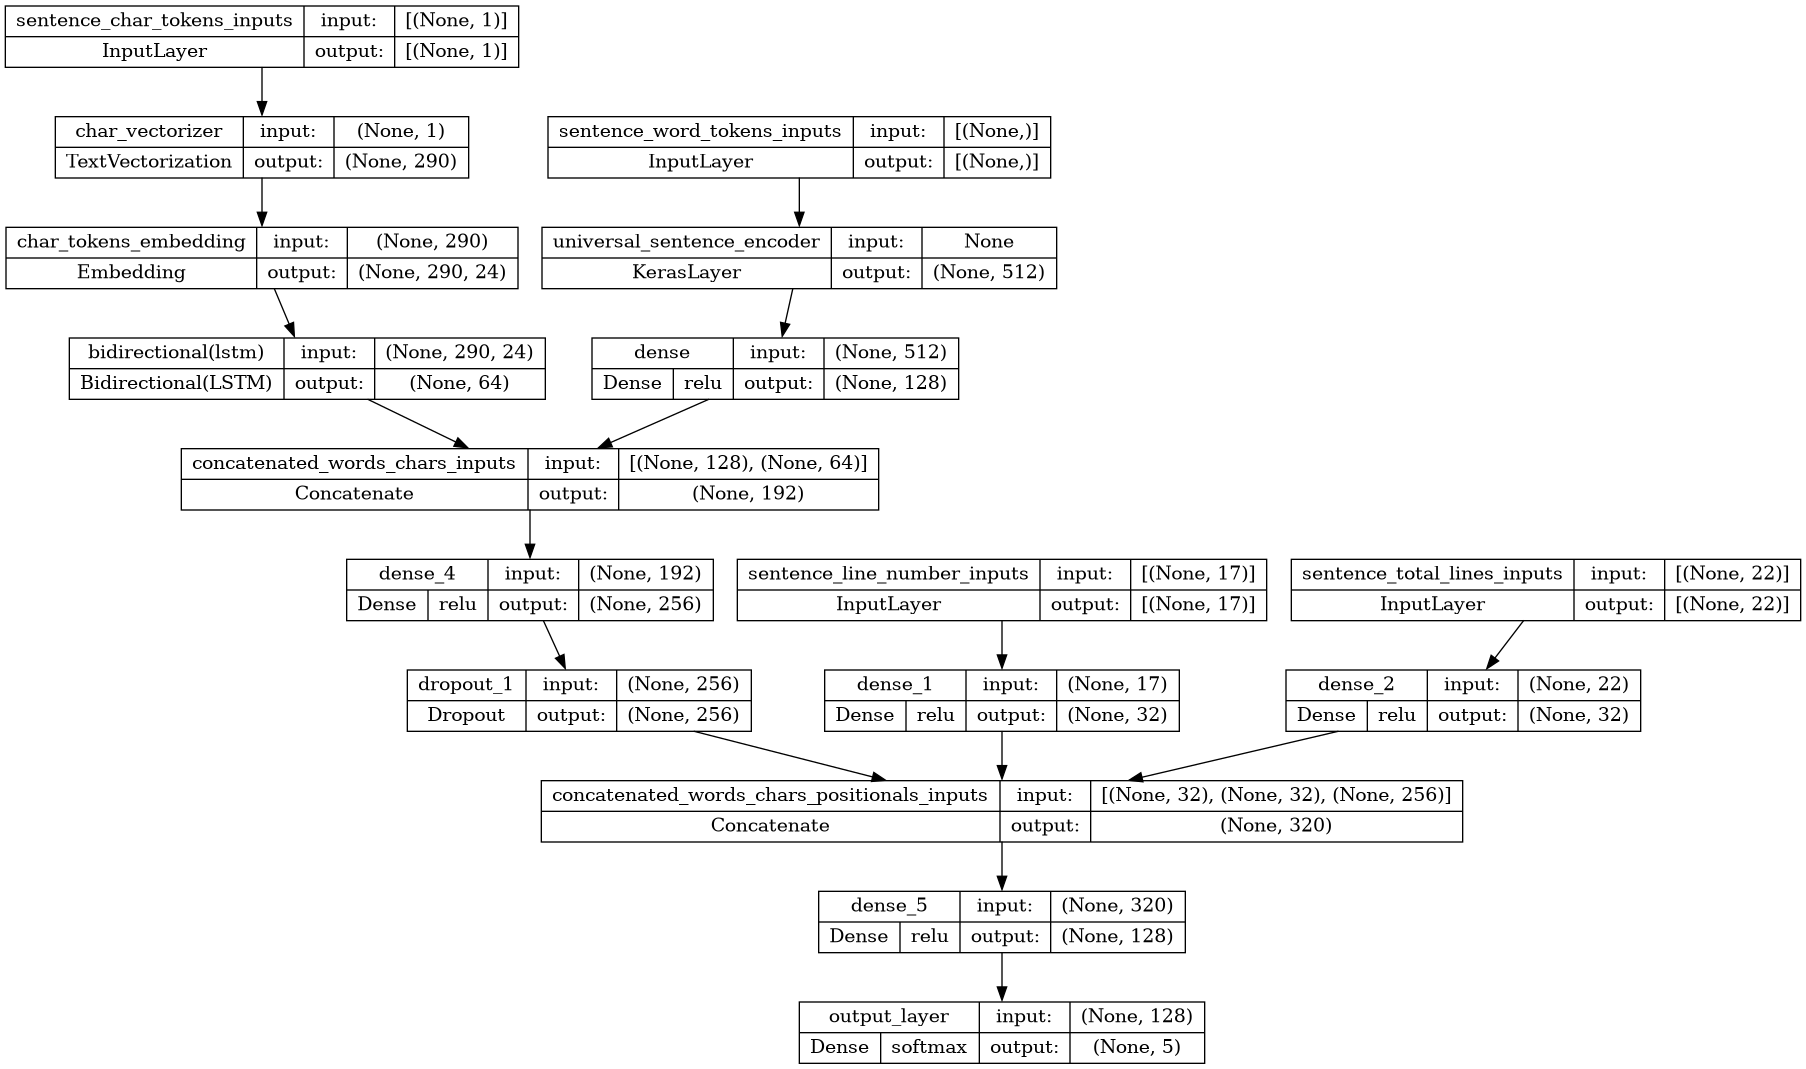

In [55]:
# modelio diagramos sudarymas
plot_model(model, show_shapes=True, show_layer_activations=True, to_file="model-img/nsk_model.png")

## Modelio mokymas

Mokymą atliekant su visai *training* duomenų rinkinio pavyzdžiais ir daugiau nei 5 epochas. Galime susidurti su situacija, kai modelis pradės mokytis iš "triukšmo", t.y. po kelis kartus pamatys labai panašius ar net tuos pačius mokymosi pavyzdžius, tai galima pastebėti praradimų (*loss*) kreivių palyginime, kai skirtumas tarp mokymo ir įvertinimo praradimų kreivių staigiai didėja.

Norint išvengti bereikalingo mokymosi iš triukšmo, sudarysime dvi papildomas [TensorFlow Callbacks](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks) funkcijas:

-[ModelCheckpoint](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint) - po kiekvienos epochos išsaugos modelio mokymosi parametrų (weights) stadiją jei stebimas parametras pagerėjo.
-[EarlyStopping](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping) - sustabdys tolesnį modelio mokymasi, jei stebimas parametras per nurodytą skaičių mokymosi epochų nepagerėjo.

### Callback funkcijos

In [ ]:
# TensorBoard callback funkcijos sudarymas
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir="tensorboard",  # aplankas kur saugoti log failus
)

In [ ]:
# ModelCheckpoint callback funkcijos sudarymas
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="checkpoints/nsk_model.ckpt",  # failo, kuriame saugosime atskaitos tašką pavadinimas
    monitor="val_accuracy",                 # stebimas parametras, kurio atžvilgiu kursime taškus (įvertinimo tikslumas)
    verbose=0,                              # išjungiam funkcijos pranešimus
    save_best_only=True,                    # nurodom saugoti tik modelį esant geriausiam stebimam parametrui
    save_weights_only=True,                 # saugojam tik įverčius, bet ne visą modelį
    save_freq='epoch',                      # kaip dažnai vertinti stebimą parametrą
)

In [ ]:
# EarlyStopping callback fnkcijos sudarymas
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",         # parametras, kurio pokyčiai bus stebimi
    min_delta=0.001,            # dydis nurodantis koks mažiausias stebimo parametro teigiamas pokytis yra priimtinas
    patience=5,                 # kiek epochų laukti stebimo parametro pokyčio, prieš sustabdant mokymą
    verbose=0,                  # išjungiam funkcijos pranešimus
    restore_best_weights=True,  # atstatyti modelio stadiją su geriausiasiais mokymosi rezultatais
)